In [1]:
%load_ext autoreload
%autoreload 2

# Placeholder graphs
Graphs with dummy data

# Resources
- https://medium.com/@andykashyap/top-5-tricks-to-make-plots-look-better-9f6e687c1e08

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.cm as cm
import matplotlib.colors as mcolors

import seaborn as sns

In [3]:
style.use('seaborn-poster') #sets the size of the charts
style.use('ggplot')
sns.set(context="talk", style="ticks", font_scale=1.5)

In [4]:
style.available

['seaborn-notebook',
 '_classic_test',
 'bmh',
 'seaborn-dark',
 'seaborn-bright',
 'grayscale',
 'tableau-colorblind10',
 'dark_background',
 'seaborn-pastel',
 'seaborn-white',
 'seaborn-muted',
 'Solarize_Light2',
 'fast',
 'seaborn',
 'seaborn-colorblind',
 'seaborn-whitegrid',
 'seaborn-talk',
 'seaborn-paper',
 'ggplot',
 'seaborn-dark-palette',
 'seaborn-poster',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'seaborn-deep',
 'fivethirtyeight',
 'classic']

In [5]:
import matplotlib.font_manager
from IPython.core.display import HTML

def make_html(fontname):
    return "<p>{font}: <span style='font-family:{font}; font-size: 24px;'>{font}</p>".format(font=fontname)

code = "\n".join([make_html(font) for font in sorted(set([f.name for f in matplotlib.font_manager.fontManager.ttflist]))])

HTML("<div style='column-count: 2;'>{}</div>".format(code))

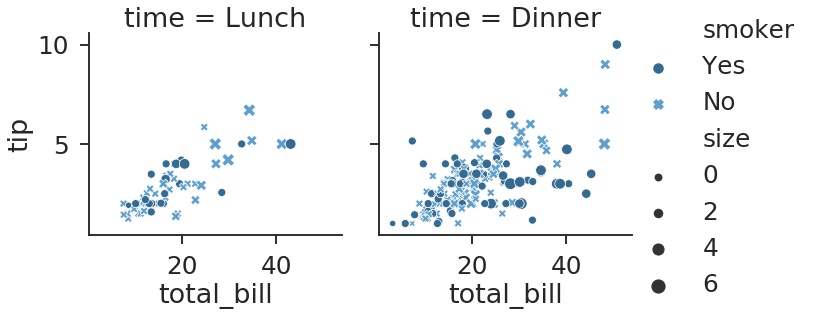

In [6]:
tips = sns.load_dataset("tips")
sns.relplot(x="total_bill", y="tip", col="time",
            hue="smoker", style="smoker", size="size",
            data=tips, palette=("Blues_d"));

# Chapter 0: Overview

In [7]:
benchmarks = ["500.perlbench_r", "502.gcc_r", "503.bwaves_r", "527.cam4_r", "541.leela_r", "549.fotonik3d_r", "554.roms_r", "557.xz_r"]
classifiers = ["SimPoint", "BBV", "INS", "BR", "PROC"]

## Why are phases important?

In [8]:
scaling_data = pd.read_csv("./csv/scaling.csv")
scaling_data.Scale = scaling_data.Scale.astype(str)

In [9]:
scaling_data

,Scale,TAGE 8KB,TAGE 64KB,Perfect BP,Perfect BP & L1D
0,1,1.00,1.01,1.20,1.50
1,2,1.25,1.27,1.65,2.10
2,4,1.46,1.49,2.04,2.60
3,8,1.60,1.64,2.35,3.04
4,16,1.70,1.75,2.60,3.42
5,32,1.74,1.80,2.80,3.60


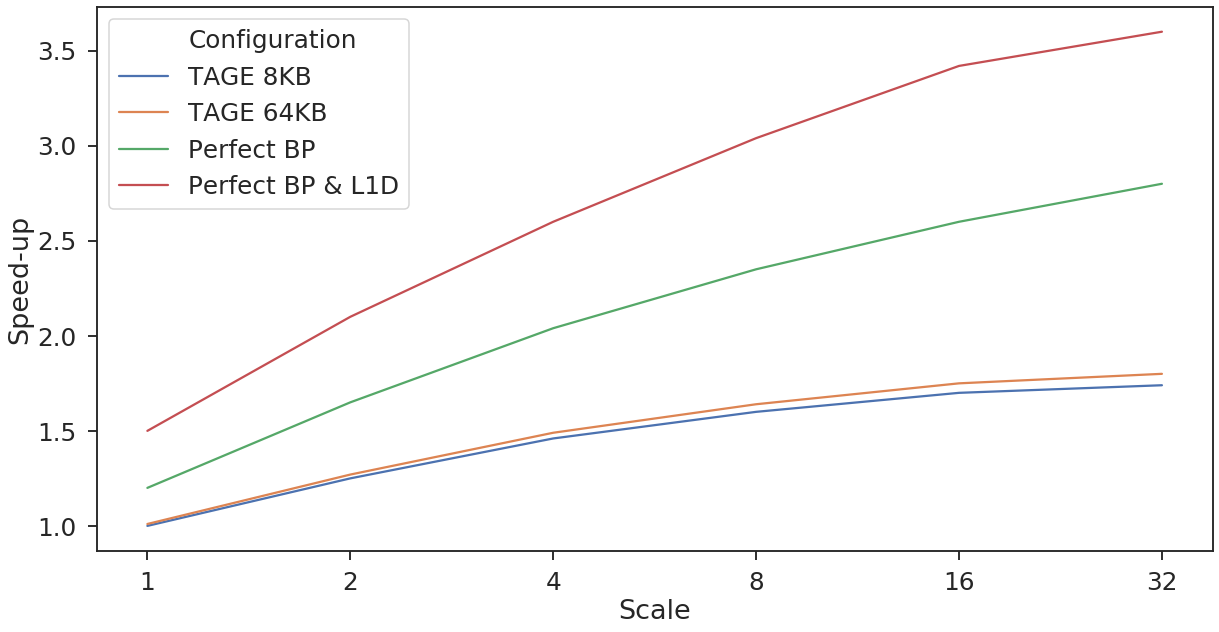

In [10]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
sns.lineplot(data=pd.melt(scaling_data, ["Scale"], var_name="Configuration", value_name="Speed-up"), ax=ax, x="Scale",y="Speed-up", hue="Configuration", sort=False)

# Chapter 1: Techniques for online phase classification

## 1. How well does the classifier aid adaptation?

In [11]:
energy_bwaves_data = pd.read_csv("./csv/energy_bwaves.csv")

In [12]:
energy_bwaves_data

,Classifier,KJ
0,Original,34.415
1,SimPoint,35.430
2,BBV,34.100
3,INS,32.500
4,BR,28.100
5,PROC,29.500


Text(0, 0.5, 'Total Energy (KJ)')

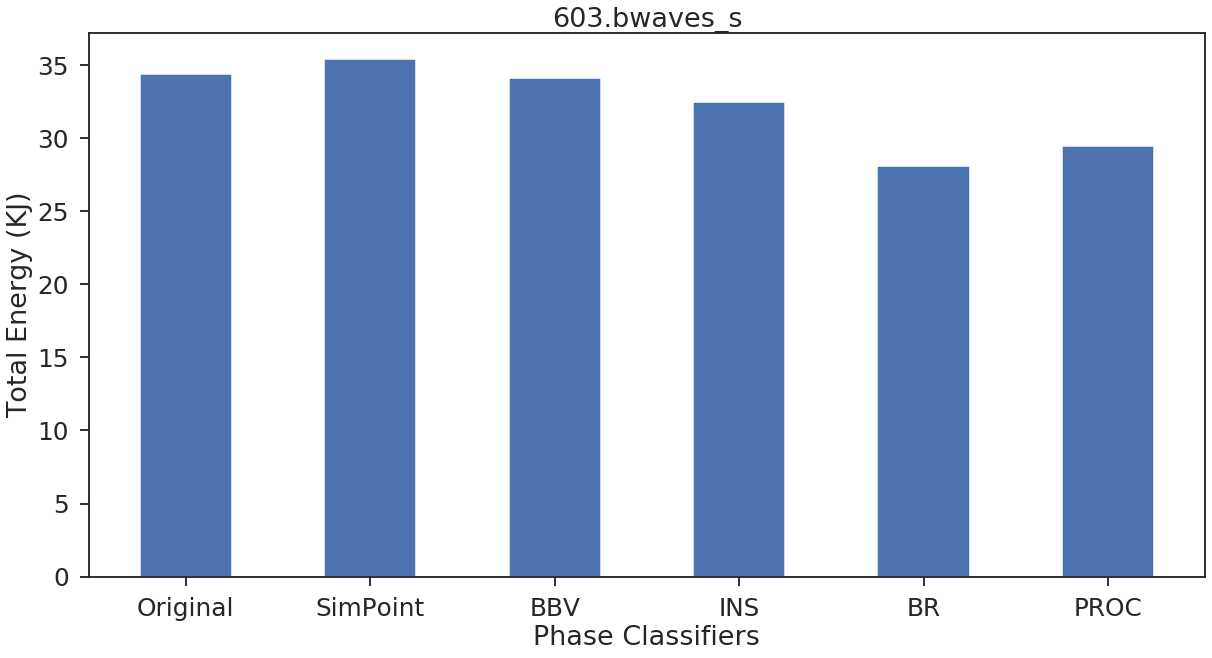

In [13]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.bar(energy_bwaves_data.Classifier, energy_bwaves_data.KJ, width=0.5)
plt.title("603.bwaves_s")
plt.xlabel("Phase Classifiers")
plt.ylabel("Total Energy (KJ)")

In [14]:
energy_data = np.random.rand(len(classifiers), len(benchmarks))

In [15]:
energy_data

array([[0.77518621, 0.73563292, 0.57784302, 0.3795195 , 0.49574687,
        0.00432171, 0.20169089, 0.73783783],
       [0.95440522, 0.92662158, 0.89397725, 0.50589178, 0.40809583,
        0.67045799, 0.72047514, 0.19529578],
       [0.95626063, 0.00449584, 0.00446384, 0.31931281, 0.04157083,
        0.37026225, 0.90358312, 0.87049817],
       [0.14785758, 0.69662626, 0.02820676, 0.73975772, 0.20783293,
        0.95748735, 0.818322  , 0.93760953],
       [0.12556871, 0.93255965, 0.9373316 , 0.90234349, 0.78698521,
        0.36201261, 0.75646055, 0.87670813]])

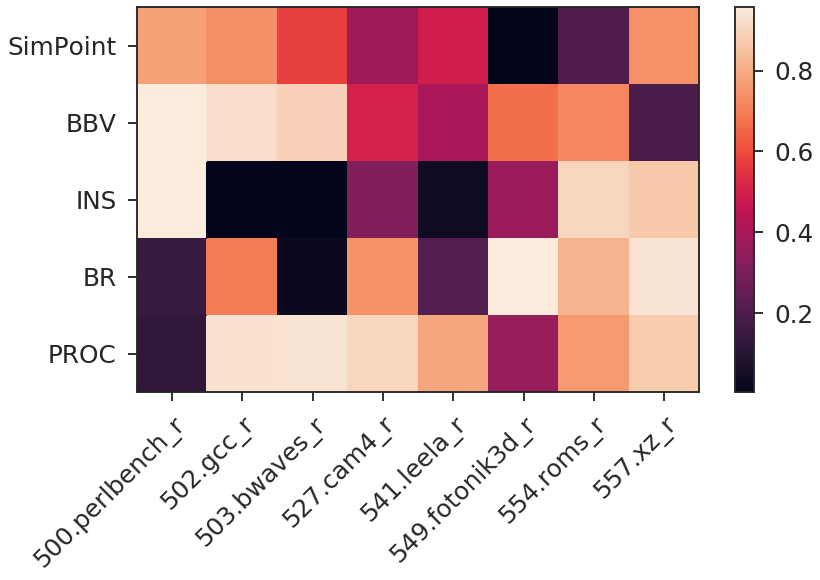

In [16]:
fig, ax = plt.subplots()

# We want to show all ticks...
ax.set_xticks(np.arange(len(benchmarks)))
ax.set_yticks(np.arange(len(classifiers)))

# ... and label them with the respective list entries
ax.set_xticklabels(benchmarks)
ax.set_yticklabels(classifiers)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

fig.tight_layout()

ax.set_xticks(np.arange(energy_data.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(energy_data.shape[0]) + 0.5, minor=False)
ax.invert_yaxis()

plt.colorbar(plt.pcolor(energy_data))

In [17]:
bp_bwaves_data = pd.read_csv("./csv/bp_bwaves.csv")

In [18]:
energy_bwaves_data

,Classifier,KJ
0,Original,34.415
1,SimPoint,35.430
2,BBV,34.100
3,INS,32.500
4,BR,28.100
5,PROC,29.500


Text(0, 0.5, 'Mispredicts per 1K instructions (MPKI)')

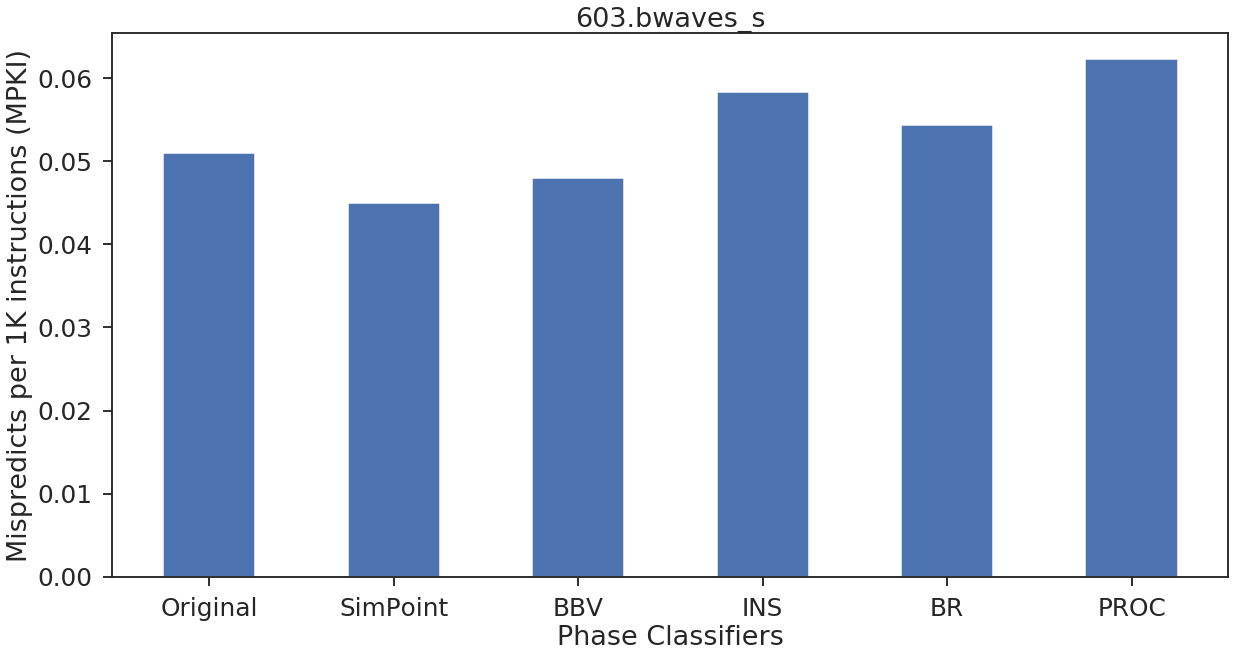

In [19]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 10)
ax.bar(bp_bwaves_data.Classifier, bp_bwaves_data.MPKI, width=0.5)
plt.title("603.bwaves_s")
plt.xlabel("Phase Classifiers")
plt.ylabel("Mispredicts per 1K instructions (MPKI)")

# 2. How well were phases detected

In [20]:
detection_data = pd.read_csv("./csv/detection.csv")

In [21]:
detection_data

,SimPoint,BBV,INS,BR,PROC
0,951.088984,945.980086,836.415680,1160.871188,953.266953
1,950.620883,945.558795,835.807148,1160.496707,951.862650
2,950.109724,945.098752,835.142641,1160.087779,950.329173
3,950.095515,945.085964,835.124170,1160.076412,950.286546
4,950.141142,945.127028,835.183484,1160.112913,950.423425
...,...,...,...,...,...
995,979.434986,971.491487,873.265481,1183.547988,1038.304956
996,985.441487,976.897338,881.073933,1188.353190,1056.324462
997,955.890968,950.301871,842.658258,1164.712774,967.672903
998,996.692771,987.023494,895.700603,1197.354217,1090.078314
